# 1. Pre-requisites
## 1.1 Import packages

In [1]:
import gzip
import json
import warnings

import matplotlib as mpl
import matplotlib.pyplot as plt
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout
import numpy as np
import pandas as pd
import pronto
from pyspark.conf import SparkConf
from pyspark.sql import SparkSession
from pyspark.sql.functions import arrays_zip, explode, map_keys, col
import pyspark.sql.functions as f
from scipy.stats import gaussian_kde
import seaborn as sns
from IPython import display

## 1.2 Read in Tabula Sapiens median expression dataframe

In [2]:
tabula_sapiens = pd.read_pickle('final_tabula_adjusted_median_drop_na.pkl', compression = 'gzip')

tabula_sapiens

ENSG00000227232  ENSG00000238009  \
tissue         cell_type                                                       
UBERON:0000016 b cell                                   NaN              NaN   
               endothelial cell                         NaN              NaN   
               mast cell                                NaN              NaN   
               myeloid cell                             NaN              NaN   
               pancreatic acinar cell                   NaN              NaN   
...                                                     ...              ...   
UBERON:0018707 plasma cell                              NaN              NaN   
               plasmacytoid dendritic cell              NaN              NaN   
               smooth muscle cell                       NaN              NaN   
               t cell                                   NaN              NaN   
               vein endothelial cell                    NaN              NaN   

                                            ENSG00000233750  ENSG00000268903  \
tissue         cell_type                                                       
UBERON:0000016 b cell                                   NaN              NaN   
               endothelial cell                         NaN              NaN   
               mast cell                                NaN              NaN   
               myeloid cell                             NaN              NaN   
               pancreatic acinar cell                   NaN              NaN   
...                                                     ...              ...   
UBERON:0018707 plasma cell                              NaN              NaN   
               plasmacytoid dendritic cell              NaN              NaN   
               smooth muscle cell                       NaN              NaN   
               t cell                                   NaN              NaN   
               vein endothelial cell                    NaN              NaN   

                                            ENSG00000269981  ENSG00000241860  \
tissue         cell_type                                                       
UBERON:0000016 b cell                                   NaN              NaN   
               endothelial cell                         NaN              NaN   
               mast cell                                NaN              NaN   
               myeloid cell                             NaN              NaN   
               pancreatic acinar cell                   NaN              NaN   
...                                                     ...              ...   
UBERON:0018707 plasma cell                              NaN              NaN   
               plasmacytoid dendritic cell              NaN              NaN   
               smooth muscle cell                       NaN              NaN   
               t cell                                   NaN              NaN   
               vein endothelial cell                    NaN              NaN   

                                            ENSG00000241599  ENSG00000279457  \
tissue         cell_type                                                       
UBERON:0000016 b cell                                   NaN              NaN   
               endothelial cell                         NaN              NaN   
               mast cell                                NaN              NaN   
               myeloid cell                             NaN              NaN   
               pancreatic acinar cell                   NaN              NaN   
...                                                     ...              ...   
UBERON:0018707 plasma cell                              NaN              NaN   
               plasmacytoid dendritic cell              NaN              NaN   
               smooth muscle cell                       NaN              NaN   
               t cell                    

## 1.3 Reformat Tabula Sapiens for specificity analysis

In [4]:
#reset index
tabula_sapiens = tabula_sapiens.reset_index()

#merge together strings from tissue and cell type columns
tissue_cell_type = tabula_sapiens['tissue'].astype(str) + '/' + tabula_sapiens['cell_type'].astype(str)

#insert new column into dataframe
tabula_sapiens.insert(0, 'tissue_cell_type', tissue_cell_type)

#remove previous tissue and cell type columns from dataframe
tabula_sapiens = tabula_sapiens.drop(columns = ['tissue', 'cell_type'])

#set tissue_cell_type as index
tabula_sapiens = tabula_sapiens.set_index('tissue_cell_type')

#tranpose table so genes are rows
tabula_sapiens = tabula_sapiens.T

In [5]:
tabula_sapiens

tissue_cell_type,UBERON:0000016/b cell,UBERON:0000016/endothelial cell,UBERON:0000016/mast cell,UBERON:0000016/myeloid cell,UBERON:0000016/pancreatic acinar cell,UBERON:0000016/pancreatic alpha cell,UBERON:0000016/pancreatic beta cell,UBERON:0000016/pancreatic ductal cell,UBERON:0000016/pancreatic pp cell,UBERON:0000016/pancreatic stellate cell,...,UBERON:0018707/macrophage,UBERON:0018707/mast cell,UBERON:0018707/myofibroblast cell,UBERON:0018707/nk cell,UBERON:0018707/pericyte cell,UBERON:0018707/plasma cell,UBERON:0018707/plasmacytoid dendritic cell,UBERON:0018707/smooth muscle cell,UBERON:0018707/t cell,UBERON:0018707/vein endothelial cell
ENSG00000227232,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,182.832504,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ENSG00000238009,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,22025.464844,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ENSG00000233750,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,15937.101562,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ENSG00000268903,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,156.842438,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ENSG00000269981,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000198695,3.489092,2.679963,4.014368,4.754292,3.565895,10.730105,NaN,3.254530,20.681417,NaN,...,2.864313,5.147031,2.396611,4.926093,2.856090,1.975962,NaN,3.201281,4.768910,3.532256
ENSG00000210194,13.395752,44.480511,NaN,5.817049,19.759800,75.670105,NaN,4.384467,21.783213,NaN,...,10.472430,2.486131,11.702745,NaN,6.794537,1.906330,NaN,6.694295,36.772465,6.673464
ENSG00000198727,40.021950,41.907898,60.740822,30.588665,29.607697,66.148064,91.813042,147.611801,144.078552,NaN,...,31.003387,79.626801,42.324898,29.035542,64.616829,11.519205,26.677158,88.981812,35.843376,55.026272
ENSG00000210195,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.958794,NaN,NaN,...,33.565372,NaN,27.510916,8.583153,26.636036,NaN,NaN,12.087816,359.533264,5.575330


In [6]:
tabula_sapiens.to_pickle('tabula_gini_input.pkl', compression = 'gzip')

## 1.4 Read in GTEx data

In [7]:
GTEx = pd.read_pickle('uberon_id_GTEx_gene_ensemblid.pkl', compression = 'gzip')

#transpose dataframe to match Tabula Sapiens
GTEx = GTEx.T

In [8]:
GTEx

,UBERON:0002190,UBERON:0010414,UBERON:0002369,UBERON:0000947,UBERON:0001621,UBERON:0007610,UBERON:0001255,UBERON:0001876,UBERON:0009835,UBERON:0001873,...,UBERON:0036149,UBERON:0004264,UBERON:0001211,UBERON:0002106,UBERON:0000945,UBERON:0000473,UBERON:0002046,UBERON:0000995,UBERON:0000996,UBERON:0000178
ENSG00000223972,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.166403,0.000000,0.000000,0.000000,0.00000
ENSG00000227232,4.064030,3.371110,2.685490,4.047620,3.90076,3.639630,5.16375,1.438590,1.692850,1.566050,...,5.932980,6.132650,4.193780,5.926310,3.062480,4.702530,6.272550,7.190010,5.745540,2.64743
ENSG00000243485,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,0.024264,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.054223,0.000000,0.000000,0.000000,0.00000
ENSG00000268020,0.000000,0.000000,0.036395,0.000000,0.00000,0.000000,0.03547,0.049672,0.053535,0.045572,...,0.026716,0.000000,0.035408,0.000000,0.032590,0.000000,0.000000,0.000000,0.000000,0.00000
ENSG00000240361,0.040648,0.040701,0.054385,0.029209,0.00000,0.039301,0.00000,0.063831,0.067951,0.072035,...,0.043017,0.042041,0.039578,0.000000,0.047112,0.053578,0.039058,0.016333,0.027464,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000198695,3517.220000,3598.090000,6637.790000,6374.490000,4972.73000,4635.000000,8275.20000,9631.770000,8319.140000,11516.600000,...,8919.460000,8113.220000,9764.490000,5477.360000,9628.750000,1676.590000,2520.410000,3644.000000,2237.430000,960.29100
ENSG00000210194,11.903800,11.203400,24.413900,22.659400,20.58800,18.257600,27.50560,40.588600,31.354900,78.695300,...,32.932100,31.334000,35.456000,24.934900,33.496300,2.871770,5.795670,10.370100,5.724510,3.49736
ENSG00000198727,23839.100000,25511.700000,28799.400000,12919.400000,15943.20000,13051.500000,23663.20000,32931.800000,28346.700000,40960.000000,...,19058.200000,17223.100000,24521.300000,11578.600000,27193.100000,15337.800000,19868.500000,15025.000000,12803.400000,2305.49000
ENSG00000210195,0.616205,0.697191,1.509280,0.000000,0.00000,0.544659,0.00000,3.444760,3.479880,5.581470,...,0.884701,1.113640,0.815455,0.783492,0.803858,0.443781,0.000000,0.000000,0.000000,0.00000


# 2. Gini Coefficient
## 2.1 Define Gini coefficient function

[Gini coefficient](https://en.wikipedia.org/wiki/Gini_coefficient) is a metric that originates from economics and describes the level of inequality between factors. It ranges from 0 (perfect equality) to 1 (maximum inequality). The application to this dataset could reveal differences in median expression across our geneset.

In [9]:
# Adapted from https://github.com/oliviaguest/gini/blob/master/gini.py
def gini(row):
    """Calculate the Gini coefficient of a Pandas row."""
    assert min(row) >= 0
    if (max(row) == 0):
        return np.nan
    # # Values cannot be 0:  (disabled because zeroes are filtered out already)
    # array += 0.0000001
    # Values must be sorted:
    array = np.sort(row)
    # Index per array element:
    index = np.arange(1,array.shape[0]+1)
    # Number of array elements:
    n = array.shape[0]
    # Gini coefficient:
    return ((np.sum((2 * index - n  - 1) * array)) / (n * np.sum(array)))

## 2.2 Calculate Gini coefficient for each gene in Tabula Sapiens

In [10]:
tabula_sapiens = pd.read_pickle('tabula_gini_input.pkl', compression = 'gzip')

In [11]:
#define the genes as index for the gini_df
gini_df = pd.DataFrame(tabula_sapiens.index)

#rename column as ensemblid and set as index
gini_df = gini_df.rename(columns = {0: 'ensemblid'})
gini_df = gini_df.set_index('ensemblid')

#fill in NaN with zeros and apply gini function across each gene
gini_df['gini'] = tabula_sapiens.fillna(0).apply(gini, axis = 1)

In [12]:
#sort Gini values starting with the maximum values
gini_df.sort_values(by = 'gini', ascending = False)

,gini
ensemblid,
ENSG00000254081,0.998700
ENSG00000234569,0.998700
ENSG00000226387,0.998700
ENSG00000215002,0.998700
ENSG00000203434,0.998700
...,...
ENSG00000107223,0.369096
ENSG00000122566,0.368352
ENSG00000165119,0.365086


Here, it appears that there is a maximum for the Gini coefficient of 0.998700 for our analyses.

## 2.3 Plot histogram of Gini coefficient values for all genes

<AxesSubplot:xlabel='gini', ylabel='Count'>

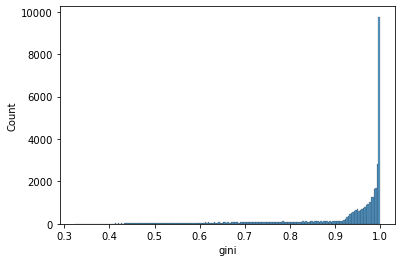

In [13]:
sns.histplot(data = gini_df, x = 'gini', bins = 200)

We see a spike of highly specifically expressed genes. However, many genes will have a low total expression which is close to zero but not exactly zero meaning they wouldn't be filtered out by the zero-expression filter step. These genes will often erroneously produce very high Gini coefficients by chance; in order to check, the Gini coefficients vs the maximum median values for the gene can be plotted.

## 2.4 Gini coefficients vs adjusted median expression (max values)

In [14]:
def gini_vs_expression(x, y):
    # From: https://stackoverflow.com/a/20107592
    xy = np.vstack([x, y])
    z = gaussian_kde(xy)(xy)
    plt.set_cmap('jet')
    fig, ax = plt.subplots()
    ax.scatter(x, y, c=z, s=2)
    ax.set_xlabel('log10 expression across all tissues')
    ax.set_ylabel('Gini coefficient of gene expression')
    plt.show()

<Figure size 432x288 with 0 Axes>

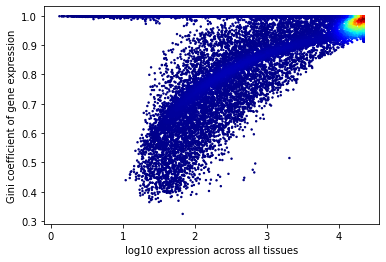

In [15]:
gini_df['maximum_adjusted_median_expression'] = tabula_sapiens.max(axis = 1)
gini_df['log_max'] = np.log10(gini_df.maximum_adjusted_median_expression)
gini_vs_expression(gini_df.log_max, gini_df.gini)

We don't need a threshold here as we already have used a minimum expression threshold of 1 CPM to calculate the median expressions.

# 3. Human Protein Atlas specificity metrics

The HPA specificity metrics have two dimensions: **specificity** and **distribution**.

## 3.1 HPA specificity categories

| Category        | Description                                                                                                                                                                                |
|:----------------|:-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| Enriched        | nTPM in a particular tissue/region/cell type at least four times any other tissue/region/cell type                                                                                         |
| Group enriched  | nTPM in a group (of 2-5 tissues, brain regions, single cell types or cell lines, or 2-10 blood cell types) at least four times any other tissue/region/cell line/blood cell type/cell type |
| Enhanced        | nTPM in a one or several (1-5 tissues, brain regions or cell lines, or 1-10 immune cell types or single cell types) at least four times the mean of other tissue/region/cell types         |
| Low specificity | nTPM ≥ 1 in at least one tissue/region/cell type but not elevated in any tissue/region/cell type                                                                                           |
| Not detected    | nTPM < 1 in all tissue/region/cell types                                                                                                                                                   |

## 3.2 HPA distribution categories

| Category           | Description                                                                     |
|:-------------------|:--------------------------------------------------------------------------------|
| Detected in single | Detected in a single tissue/region/cell type                                    |
| Detected in some   | Detected in more than one but less than one third of tissues/regions/cell types |
| Detected in many   | Detected in at least a third but not all tissues/regions/cell types             |
| Detected in all    | Detected in all tissues/regions/cell types                                      |
| Not detected       | nTPM < 1 in all tissues/regions/cell types                                      |

## 3.3 Apply single-cell HPA definitions to Tabula Sapiens data

In [18]:
THRESHOLD = 1.0

def hpa_specificity(row):
    expr = sorted(row)
    if expr[-1] < THRESHOLD:
        return 'Not detected'
    if expr[-2] == 0 or expr[-1]/expr[-2] >= 4.0:
        return 'Individually enriched'
    for i in range(2, 6):
        if expr[-i-1] == 0 or expr[-i] / expr[-i-1] >= 4.0:
            return 'Group enriched'
    mean = sum(expr) / len(row)
    if 1 <= sum([e / mean >= 4.0 for e in expr]) <= 10:
        return 'Individually enhanced'
    return 'Low specificity'

def hpa_distribution(row):
    expr = sorted(row)
    if expr[-1] < THRESHOLD:
        return 'Not detected'
    num_detected = sum([e > THRESHOLD for e in expr])
    if num_detected == 1:
        return 'Detected in single'
    if num_detected < len(row) / 3:
        return 'Detected in some'
    if num_detected < len(row):
        return 'Detected in many'
    return 'Detected in all'

In [19]:
#fill NaNs with zeros to account for undetected expression in cell types
gini_df['hpa_specificity'] = tabula_sapiens.fillna(0).apply(hpa_specificity, axis = 1)
gini_df['hpa_distribution'] = tabula_sapiens.fillna(0).apply(hpa_distribution, axis = 1)

In [20]:
gini_df

,gini,maximum_adjusted_median_expression,log_max,hpa_specificity,hpa_distribution
ensemblid,,,,,
ENSG00000227232,0.994666,22025.464844,4.342926,Group enriched,Detected in some
ENSG00000238009,0.960035,22025.464844,4.342926,Low specificity,Detected in some
ENSG00000233750,0.988349,22025.464844,4.342926,Individually enhanced,Detected in some
ENSG00000268903,0.981275,22025.464844,4.342926,Low specificity,Detected in some
ENSG00000269981,0.994798,22025.464844,4.342926,Group enriched,Detected in some
...,...,...,...,...,...
ENSG00000198695,0.496340,60.438301,1.781312,Low specificity,Detected in many
ENSG00000210194,0.841466,143.026062,2.155415,Low specificity,Detected in many
ENSG00000198727,0.447636,485.283173,2.685995,Individually enhanced,Detected in many


In [21]:
#genes that are highly specific to one cell type
gini_df[gini_df.hpa_specificity == 'Individually enriched'].sort_values(by = 'gini', ascending = False)

,gini,maximum_adjusted_median_expression,log_max,hpa_specificity,hpa_distribution
ensemblid,,,,,
ENSG00000273443,0.998700,22025.464844,4.342926,Individually enriched,Detected in single
ENSG00000256159,0.998700,22025.464844,4.342926,Individually enriched,Detected in single
ENSG00000257756,0.998700,11192.734375,4.048936,Individually enriched,Detected in single
ENSG00000256512,0.998700,22025.464844,4.342926,Individually enriched,Detected in single
ENSG00000256226,0.998700,22025.464844,4.342926,Individually enriched,Detected in single
...,...,...,...,...,...
ENSG00000108848,0.468295,157.542084,2.197397,Individually enriched,Detected in many
ENSG00000124795,0.460936,292.550934,2.466202,Individually enriched,Detected in many
ENSG00000164346,0.438628,87.399033,1.941507,Individually enriched,Detected in many


In [22]:
tabula_sapiens.loc['ENSG00000273443'].dropna()

tissue_cell_type
UBERON:0018707/bladder urothelial cell    22025.464844
Name: ENSG00000273443, dtype: float32

Here we see the gene with the top Gini result for the single cell type enriched group is only detected in one cell type (bladder urothelial cell), as demonstrated by the hpa_distribution categorisation, which has the maximum expression of it (max threshold for Tabula Sapiens count data).

In [23]:
tabula_sapiens.loc['ENSG00000108848'].dropna().sort_values(ascending = True)

tissue_cell_type
UBERON:0002108/plasma cell                          1.296758
UBERON:0000017/plasma cell                          1.379401
UBERON:0010032/keratinocyte                         1.493335
UBERON:0010033/keratinocyte                         1.537262
UBERON:0001911/plasma cell                          1.672193
                                                     ...    
UBERON:0002108/intestinal tuft cell                24.690405
UBERON:0000059/intestinal tuft cell                25.366571
UBERON:0000016/pancreatic pp cell                  29.211235
UBERON:0002385/cd8-positive, alpha-beta t cell     36.399769
UBERON:0001831/cd4-positive, alpha-beta t cell    157.542084
Name: ENSG00000108848, Length: 578, dtype: float32

Again, we see the gene is expressed in a lot of cell types which is why the hpa_distribution is 'Detected in many' and the Gini score lower however the hpa_specificity is 'Single cell type enriched' as it has a much larger expression in a single cell type (cd4-positive, alpha-beta t cell) than in others.

## 3.4 Comparison of HPA: bulk vs single-cell

### 3.4.1 Calculate Gini and HPA metrics for GTEx

In [24]:
#filter out zero expression across all tissues
GTEx = GTEx.loc[(GTEx != 0).any(axis = 1)]

#define the genes as index for the gini_df
GTEx_gini = pd.DataFrame(GTEx.index)

#rename column as ensemblid and set as index
GTEx_gini = GTEx_gini.rename(columns = {0: 'ensemblid'})
GTEx_gini = GTEx_gini.set_index('ensemblid')

#apply gini function across each gene
GTEx_gini['GTEx_gini'] = GTEx.apply(gini, axis = 1)

In [25]:
GTEx.to_pickle('GTEx_counts_zero_filtered.pkl', compression = 'gzip')

In [26]:
#calculate HPA metrics for GTEx data
GTEx_gini['GTEx_hpa_specificity'] = GTEx.apply(hpa_specificity, axis = 1)
GTEx_gini['GTEx_hpa_distribution'] = GTEx.apply(hpa_distribution, axis = 1)

In [27]:
GTEx_gini.sort_values(by = 'GTEx_gini', ascending = False)

,GTEx_gini,GTEx_hpa_specificity,GTEx_hpa_distribution
ensemblid,,,
ENSG00000173357,0.980000,Not detected,Not detected
ENSG00000244551,0.980000,Not detected,Not detected
ENSG00000266707,0.980000,Not detected,Not detected
ENSG00000267726,0.980000,Not detected,Not detected
ENSG00000256769,0.980000,Not detected,Not detected
...,...,...,...
ENSG00000143252,0.111678,Low specificity,Detected in all
ENSG00000005075,0.109183,Low specificity,Detected in all
ENSG00000134809,0.108472,Low specificity,Detected in all


In [35]:
GTEx.loc['ENSG00000173357'].sort_values(ascending = False)

UBERON:0000473    0.089572
UBERON:0002190    0.000000
UBERON:0001150    0.000000
UBERON:0006631    0.000000
UBERON:0006566    0.000000
UBERON:0001225    0.000000
UBERON:0001293    0.000000
UBERON:0002107    0.000000
UBERON:0002048    0.000000
UBERON:0006330    0.000000
UBERON:0011907    0.000000
UBERON:0001323    0.000000
UBERON:0000992    0.000000
UBERON:0000007    0.000000
UBERON:0010414    0.000000
UBERON:0002367    0.000000
UBERON:0036149    0.000000
UBERON:0004264    0.000000
UBERON:0001211    0.000000
UBERON:0002106    0.000000
UBERON:0000945    0.000000
UBERON:0002046    0.000000
UBERON:0000995    0.000000
UBERON:0000996    0.000000
UBERON:0003889    0.000000
UBERON:0004648    0.000000
UBERON:0006920    0.000000
UBERON:0004550    0.000000
UBERON:0002369    0.000000
UBERON:0000947    0.000000
UBERON:0001621    0.000000
UBERON:0007610    0.000000
UBERON:0001255    0.000000
UBERON:0001876    0.000000
UBERON:0009835    0.000000
UBERON:0001873    0.000000
UBERON:0001870    0.000000
U

Here, we see that the reason the genes are 'Not Detected' for both HPA specificity and distribution is because the gene has an expression that is below the threshold of 1 CPM which we applied to match the Tabula Sapiens adjusted median counts. It has a high Gini score however since the expression is present in one tissue only and this score does not take a minimum expression threshold into consideration.

<AxesSubplot:xlabel='GTEx_gini', ylabel='Count'>

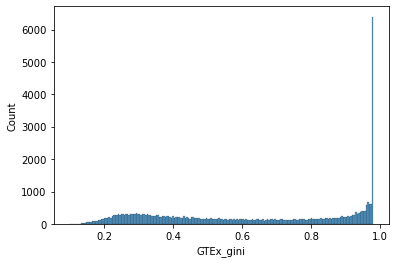

In [36]:
sns.histplot(data = GTEx_gini, x = 'GTEx_gini', bins = 200)

### 3.4.2 Gini coefficients vs maximum gene expression for GTEx (TPM)

<Figure size 432x288 with 0 Axes>

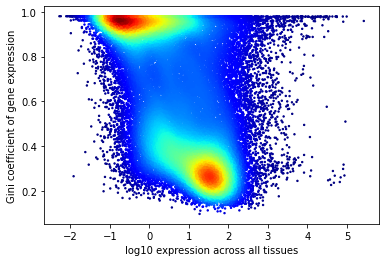

In [37]:
GTEx_gini['maximum_median_expression'] = GTEx.max(axis = 1)
GTEx_gini['log_max'] = np.log10(GTEx_gini.maximum_median_expression)
gini_vs_expression(GTEx_gini.log_max, GTEx_gini.GTEx_gini)

There are 2 clusters with the highest population of data points; most of these occur for the highest Gini coefficient in the cells with small total expressions (this will occur by chance) and the other at a lower Gini score with average total expressions across these tissues. This is different to Tabula Sapiens where most data points have a high Gini coefficient regardless of the maximum adjusted median expression across the cell type but the Gini score does appear to increase as the maximum adjusted median expression increases.

### 3.4.3 Merge Gini dataframes together from GTEx and Tabula Sapiens

In [39]:
gini_df = gini_df.drop(columns = ['log_max', 'maximum_adjusted_median_expression'])
GTEx_gini = GTEx_gini.drop(columns = ['maximum_median_expression', 'log_max'])

In [40]:
GTEx_gini.to_pickle('GTEx_gini.pkl', compression = 'gzip')
gini_df.to_pickle('tabula_gini_df.pkl', compression = 'gzip')

In [41]:
#merge gini dataframes together on index
##number of genes has decreased as retains only genes which are shared across the two dataframes (i.e. both have gini values)
gini_merged = pd.merge(gini_df, GTEx_gini, left_index=True, right_index=True)
gini_merged

,gini,hpa_specificity,hpa_distribution,GTEx_gini,GTEx_hpa_specificity,GTEx_hpa_distribution
ensemblid,,,,,,
ENSG00000227232,0.994666,Group enriched,Detected in some,0.279425,Low specificity,Detected in many
ENSG00000238009,0.960035,Low specificity,Detected in some,0.458660,Not detected,Not detected
ENSG00000233750,0.988349,Individually enhanced,Detected in some,0.623261,Not detected,Not detected
ENSG00000268903,0.981275,Low specificity,Detected in some,0.647153,Individually enhanced,Detected in many
ENSG00000269981,0.994798,Group enriched,Detected in some,0.658953,Individually enhanced,Detected in many
...,...,...,...,...,...,...
ENSG00000198695,0.496340,Low specificity,Detected in many,0.291177,Low specificity,Detected in all
ENSG00000210194,0.841466,Low specificity,Detected in many,0.364488,Low specificity,Detected in all
ENSG00000198727,0.447636,Individually enhanced,Detected in many,0.236466,Low specificity,Detected in all


In [42]:
gini_merged.to_pickle('merged_gini_HPA_metrics.pkl', compression = 'gzip')

### 3.4.4 Specificity similarity matrix

In [43]:
gini_merged = pd.read_pickle('merged_gini_HPA_metrics.pkl', compression = 'gzip')

<AxesSubplot:xlabel='GTEx_hpa_specificity', ylabel='hpa_specificity'>

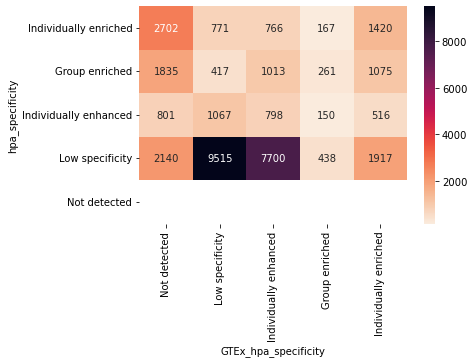

In [44]:
categories = ['Not detected', 'Low specificity', 'Individually enhanced', 'Group enriched', 'Individually enriched']
cross = pd.crosstab(gini_merged.hpa_specificity, gini_merged.GTEx_hpa_specificity)
cross = cross.reindex(categories, axis = 'columns')
cross = cross.reindex(categories[::-1], axis = 'rows')
sns.heatmap(cross, cmap = 'rocket_r', annot = True, fmt = 'g')

### 3.4.5 Distribution similarity matrix

<AxesSubplot:xlabel='GTEx_hpa_distribution', ylabel='hpa_distribution'>

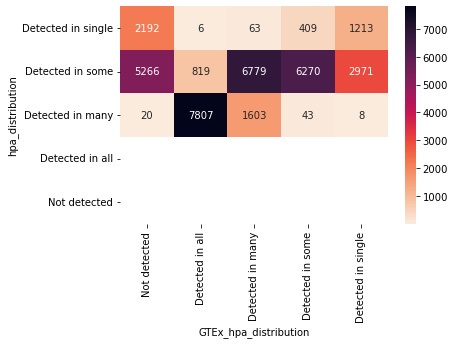

In [45]:
categories = ['Not detected', 'Detected in all', 'Detected in many', 'Detected in some', 'Detected in single']
cross = pd.crosstab(gini_merged.hpa_distribution, gini_merged.GTEx_hpa_distribution)
cross = cross.reindex(categories, axis = 'columns')
cross = cross.reindex(categories[::-1], axis = 'rows')
sns.heatmap(cross, cmap = 'rocket_r', annot = True, fmt = 'g')

We don't have any not detected since we removed these genes that had zero expression across all tissues and cell types and also for Tabula Sapiens there are none in detected in all since this is single-cell data grouped by cell type so it is unlikely the gene will be detected in all.

### 3.4.6 Gini similarity

In [46]:
def gini_vs_gini(x, y):
    # From: https://stackoverflow.com/a/20107592
    xy = np.vstack([x, y])
    z = gaussian_kde(xy)(xy)
    plt.set_cmap('jet')
    fig, ax = plt.subplots()
    ax.scatter(x, y, c=z, s=2)
    ax.set_xlabel('GTEx Gini coefficients')
    ax.set_ylabel('Tabula Sapiens Gini coefficients')
    plt.show()

<Figure size 432x288 with 0 Axes>

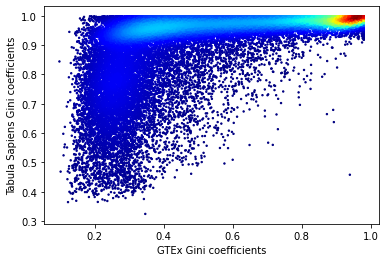

In [48]:
gini_vs_gini(gini_merged.GTEx_gini, gini_merged.gini)

This plot is as expected for the Gini values since Tabula Sapiens is expected to have high Gini values from looking at single cell data so the log curve is observed when compared against the GTEx gini values.